<a href="https://colab.research.google.com/github/priyankashinde-25/Data-Science/blob/main/AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [3]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.3-py2.py3-none-any.whl size=265293968 sha256=3996c2f2cf4e38bb8eafe751780bd25dc5727e0432ac617c0c7d09870ee8c007
  Stored in directory: /root/.cache/pip/wheels/77/9a/1c/2da26f943fd46b57f3c20b54847b936b9152b831dc7447cf71
Successfully built h2o


In [78]:
import h2o
from h2o.automl import H2OAutoML
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.gbm import H2OGradientBoostingEstimator
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split as tts
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from yellowbrick.regressor import ResidualsPlot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


In [12]:
min_mem_size=6
run_time=222

In [13]:
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

6


In [14]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)
#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:12269..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7qeliu3u
  JVM stdout: /tmp/tmp7qeliu3u/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp7qeliu3u/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:12269
Connecting to H2O server at http://127.0.0.1:12269 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 28 days
H2O_cluster_name:,H2O_from_python_unknownUser_vby2eq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [5]:
ddf = pd.read_csv(
    "https://raw.githubusercontent.com/priyankashinde-25/Data-Science/main/adult.csv"
)  # Reading CSV file into Pandas DataFrame


In [6]:
ddf.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [7]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [8]:
mapping = {'<=50K': 50001, '>50K': 49000}
ddf['income'] = ddf['income'].map(mapping)

In [9]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB


In [10]:
ddf['workclass']= ddf['workclass'].astype("category").cat.codes
ddf['education'] = ddf['education'].astype("category").cat.codes
ddf['marital-status'] = ddf['marital-status'].astype("category").cat.codes
ddf['occupation'] = ddf['occupation'].astype("category").cat.codes
ddf['relationship'] = ddf['relationship'].astype("category").cat.codes
ddf['race'] = ddf['race'].astype("category").cat.codes
ddf['gender'] = ddf['gender'].astype("category").cat.codes
ddf['native-country'] = ddf['native-country'].astype("category").cat.codes

In [11]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   age              48842 non-null  int64
 1   workclass        48842 non-null  int8 
 2   fnlwgt           48842 non-null  int64
 3   education        48842 non-null  int8 
 4   educational-num  48842 non-null  int64
 5   marital-status   48842 non-null  int8 
 6   occupation       48842 non-null  int8 
 7   relationship     48842 non-null  int8 
 8   race             48842 non-null  int8 
 9   gender           48842 non-null  int8 
 10  capital-gain     48842 non-null  int64
 11  capital-loss     48842 non-null  int64
 12  hours-per-week   48842 non-null  int64
 13  native-country   48842 non-null  int8 
 14  income           48842 non-null  int64
dtypes: int64(7), int8(8)
memory usage: 3.0 MB


In [15]:
df = h2o.H2OFrame(
    ddf
)  # Converted Pandas Dataframe to H2O dataframe to proceed with AutoML

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [16]:
df.types

{'age': 'int',
 'workclass': 'int',
 'fnlwgt': 'int',
 'education': 'int',
 'educational-num': 'int',
 'marital-status': 'int',
 'occupation': 'int',
 'relationship': 'int',
 'race': 'int',
 'gender': 'int',
 'capital-gain': 'int',
 'capital-loss': 'int',
 'hours-per-week': 'int',
 'native-country': 'int',
 'income': 'int'}

In [17]:
pct_rows = 0.80  # Setting up the data split between training and test dataset.
df_train, df_test = df.split_frame([pct_rows])

In [18]:
print(df_train.shape)
print(df_test.shape)

(39214, 15)
(9628, 15)


In [19]:
df_train.head()

age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
25,4,226802,1,7,4,7,3,2,1,0,0,40,39,50001
38,4,89814,11,9,2,5,0,4,1,0,0,50,39,50001
28,2,336951,7,12,2,11,0,4,1,0,0,40,39,49000
44,4,160323,15,10,2,7,0,2,1,7688,0,40,39,49000
18,0,103497,15,10,4,0,3,4,0,0,0,30,39,50001
34,4,198693,0,6,4,8,1,4,1,0,0,30,39,50001
29,0,227026,11,9,4,0,4,2,1,0,0,40,39,50001
24,4,369667,15,10,4,8,4,4,0,0,0,40,39,50001
55,4,104996,5,4,2,3,0,4,1,0,0,10,39,50001
36,1,212465,9,13,2,1,0,4,1,0,0,40,39,50001


In [20]:
X = df.columns
print(X)

['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


In [21]:
# Set target and predictor variables
y = "income"
X.remove(y)  # Removing the result frm our predictors data
print(X)

['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


In [22]:
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)  # Setting of AutoML

In [23]:
aml.train(x=X, y=y, training_frame=df_train)  # Trainig the dataset on different models

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_1_20240218_73311


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    69                 69                          106817                 8            8            8             49            186           118.58

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 79098.03466745978
RMSE: 281.2437282277772
MAE: 174.77503430694395
RMSLE: 0.005682529154469064
Mean Residual Deviance: 79098.03466745978

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 89359.41641997869
RMSE: 298.9304541527656
MAE: 187.25454746596205
RMSLE: 0.0060391004075074015
Mean Residual Deviance: 89359.41641997869

Cross-Validation Metrics Summary: 
                        mean        sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     187.196     3.15987      183.835       190.152       184.466       190.705       186.823
mean_residual_deviance  89374.6     2732.22      86132         92137.1       88119.8       92319.8       88164
mse                     89374.6     2732.22      86132         92137.1       88119.8       92319.8       88164
r2                      0.509581    0.017403     0.526776      0.502094      0.515854      0.482981      0.520203
residual_deviance       89374.6     2732.22      86132         92137.1       88119.8       92319.8       88164
rmse                    298.928     4.56649      293.482       303.541       296.85        303.842       296.924
rmsle                   0.00603902  9.24065e-05  0.00592881    0.00613298    0.00599722    0.00613787    0.00599825

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-02-18 07:35:27  11.115 sec  0                  426.959          364.224         182294
    2024-02-18 07:35:27  11.260 sec  5                  364.448          303.48          132822
    2024-02-18 07:35:27  11.392 sec  10                 328.424          258.826         107862
    2024-02-18 07:35:27  11.536 sec  15                 311.393          231.224         96965.7
    2024-02-18 07:35:28  11.669 sec  20                 302.189          212.644         91318.3
    2024-02-18 07:35:28  11.812 sec  25                 297.289          200.748         88380.9
    2024-02-18 07:35:28  11.950 sec  30                 293.941          192.33          86401.6
    2024-02-18 07:35:28  12.080 sec  35                 290.856          186.206         84597.1
    2024-02-18 07:35:28  12.210 sec  40                 288.757          182.737         83380.5
    2024-02-18 07:35:28  12.341 sec  45                 287.125          180.146         82440.5
    2024-02-18 07:35:28  12.488 sec  50                 285.476          178.064         81496.8
    2024-02-18 07:35:28  12.616 sec  55                 284              177.034         80655.9
    2024-02-18 07:35:29  12.763 sec  60                 282.877          176.264         80019.3
    2024-02-18 07:35:29  12.893 sec  65                 281.916          175.465         79476.8
    2024-02-18 07:35:29  12.988 sec  69                 281.244          174.775         79098

Variable Importances: 
variable         relative_importance    scaled_importance    percentage
---------------  ---------------------  -------------------  ------------
capital-gain     4.38514e+09            1                    0.230799

In [24]:
print(
    aml.leaderboard
)  # Leaderboard showing the performance of different models on the dataset.

model_id                                           rmse      mse      mae       rmsle    mean_residual_deviance
GBM_3_AutoML_1_20240218_73311                   298.93   89359.4  187.255  0.0060391                    89359.4
GBM_4_AutoML_1_20240218_73311                   299.639  89783.3  185.971  0.00605324                   89783.3
GBM_2_AutoML_1_20240218_73311                   299.701  89820.5  189.119  0.00605474                   89820.5
GBM_5_AutoML_1_20240218_73311                   300.229  90137.2  191.231  0.00606553                   90137.2
GBM_1_AutoML_1_20240218_73311                   301.781  91071.8  189.812  0.00609638                   91071.8
XGBoost_3_AutoML_1_20240218_73311               302.566  91546.3  197.076  0.0061125                    91546.3
XGBoost_grid_1_AutoML_1_20240218_73311_model_1  306.396  93878.8  196.824  0.00618932                   93878.8
XGBoost_2_AutoML_1_20240218_73311               311.165  96823.5  199.659  0.00628517                   

In [26]:
model_index = 0
glm_index = 0
glm_model = ""
aml_leaderboard_df = aml.leaderboard.as_data_frame()
models_dict = {}
for m in aml_leaderboard_df["model_id"]:
    models_dict[m] = model_index
    if "StackedEnsemble" not in m:
        break
    model_index = model_index + 1

for m in aml_leaderboard_df["model_id"]:
    if "GLM" in m:
        models_dict[m] = glm_index
        break
    glm_index = glm_index + 1
models_dict

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


{'GBM_3_AutoML_1_20240218_73311': 0, 'GLM_1_AutoML_1_20240218_73311': 13}

In [27]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index, "model_id"])

0


In [28]:
best_model.algo

'gbm'

In [29]:
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

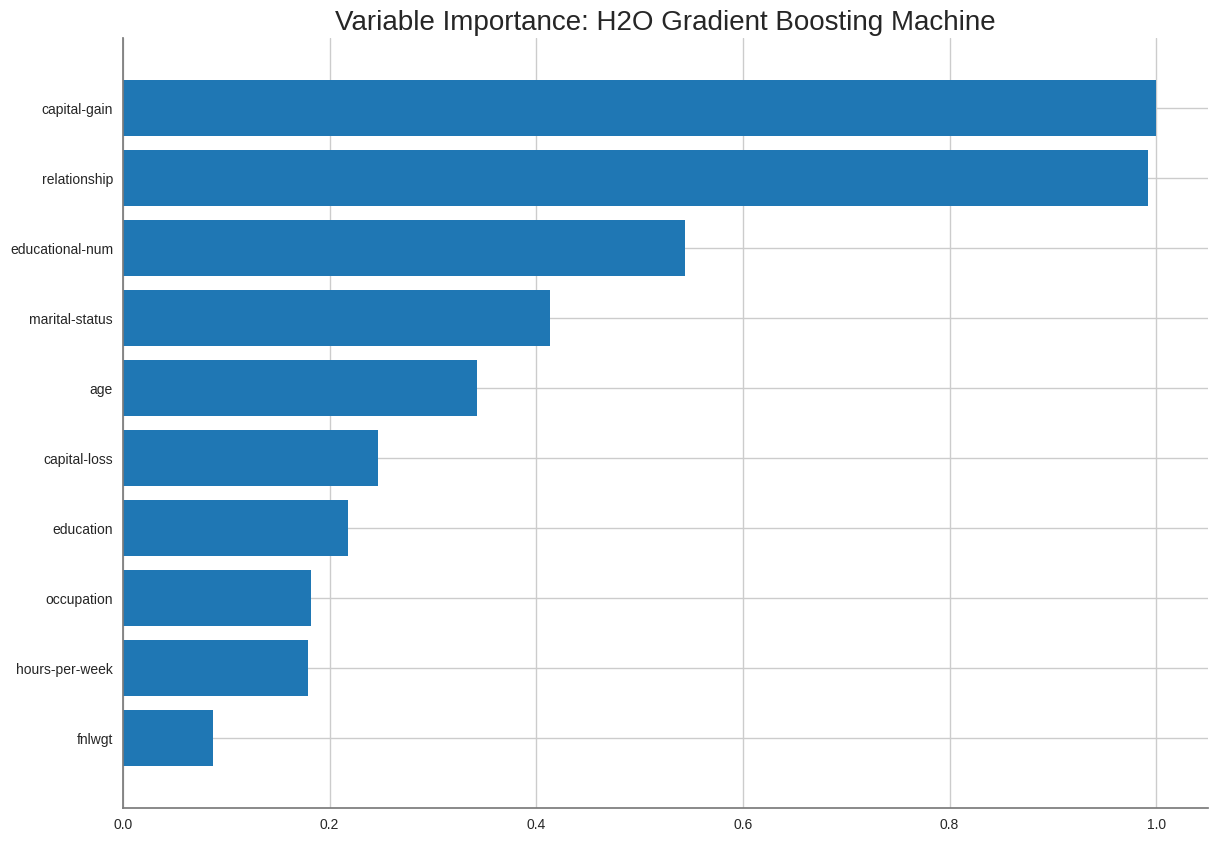

<Figure size 800x550 with 0 Axes>

In [30]:
if best_model.algo in [
    "gbm",
    "drf",
    "xrt",
    "xgboost",
]:  # Importance of all the variables in GBM algorithm.
    best_model.varimp_plot()

13
glm


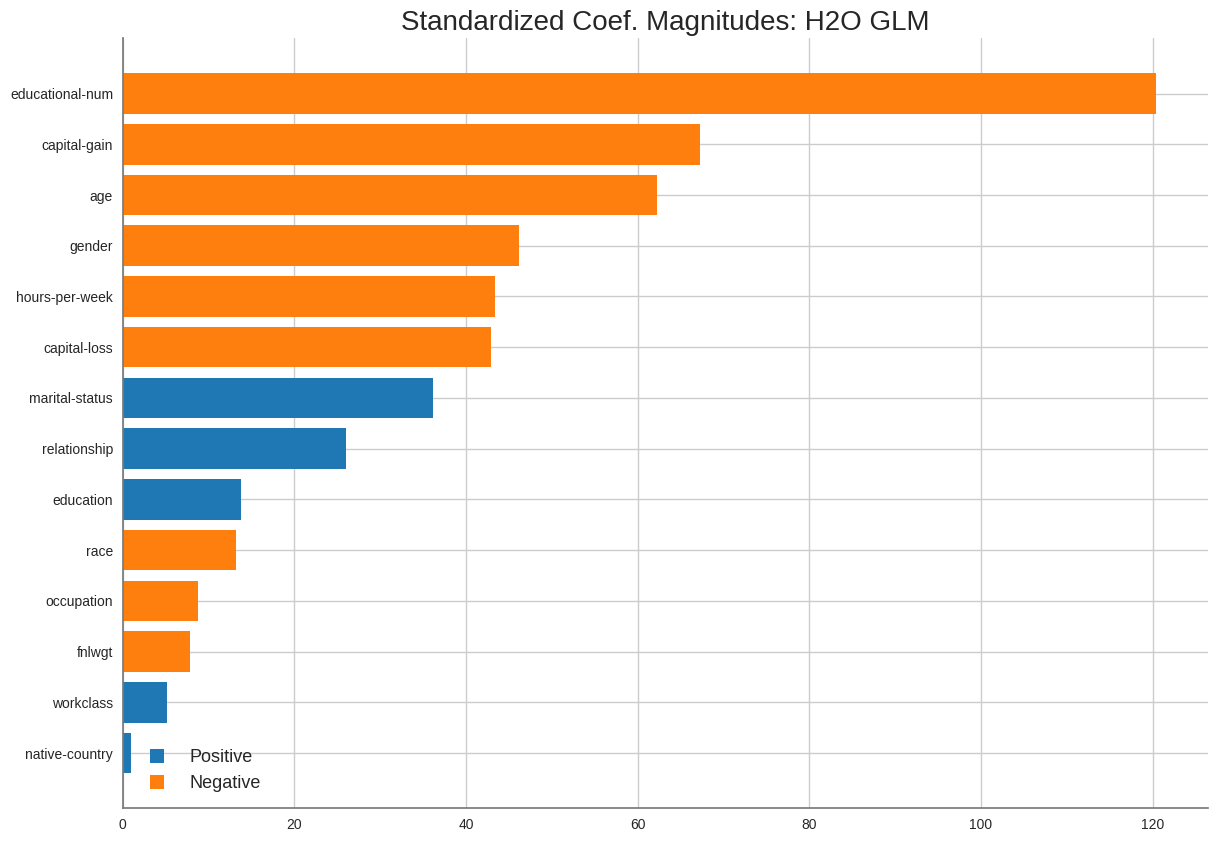

In [31]:
if glm_index is not 0:
    print(glm_index)
    glm_model = h2o.get_model(aml.leaderboard[glm_index, "model_id"])
    print(glm_model.algo)
    glm_model.std_coef_plot()

In [32]:
print(best_model.rmse(train=True))

281.2437282277772


In [33]:
def model_performance_stats(perf):
    d = {}
    try:
        d["mse"] = perf.mse()
    except:
        pass
    try:
        d["rmse"] = perf.rmse()
    except:
        pass
    try:
        d["null_degrees_of_freedom"] = perf.null_degrees_of_freedom()
    except:
        pass
    try:
        d["residual_degrees_of_freedom"] = perf.residual_degrees_of_freedom()
    except:
        pass
    try:
        d["residual_deviance"] = perf.residual_deviance()
    except:
        pass
    try:
        d["null_deviance"] = perf.null_deviance()
    except:
        pass
    try:
        d["aic"] = perf.aic()
    except:
        pass
    try:
        d["logloss"] = perf.logloss()
    except:
        pass
    try:
        d["auc"] = perf.auc()
    except:
        pass
    try:
        d["gini"] = perf.gini()
    except:
        pass
    return d

In [34]:
mod_perf = best_model.model_performance(df_test)
stats_test = {}
stats_test = model_performance_stats(mod_perf)
stats_test

{'mse': 89531.96848048459,
 'rmse': 299.21893068535053,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None}

In [35]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [36]:
y_pred = h2o.as_list(
    predictions
)  # Predictions on Test Dataset using the best model from the leaderboard.
print(y_pred)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
           predict
0     49132.119563
1     49081.293906
2     50006.218590
3     49321.258171
4     49608.237975
...            ...
9623  49941.226171
9624  49152.606246
9625  49987.135444
9626  50001.396818
9627  48960.621367

[9628 rows x 1 columns]


In [37]:
y_test = h2o.as_list(df_test[y])  # Real Answers
y_test

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


,income
0,49000
1,49000
2,50001
3,49000
4,50001
...,...
9623,50001
9624,49000
9625,50001
9626,50001


In [38]:
print(X)

['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


In [42]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

adult_glm = H2OGeneralizedLinearEstimator(
    family="gaussian", lambda_=0, compute_p_values=True, nfolds=5
)  # Elastic Net Regularization
adult_glm_regularization_ridge = H2OGeneralizedLinearEstimator(
    family="gaussian", alpha=0, nfolds=5
)  # RIDGE Regularization
adult_glm_regularization_lasso = H2OGeneralizedLinearEstimator(
    family="gaussian", alpha=1, nfolds=5
)  # LASSO Regularization
adult_glm_regularization_lamba_search = H2OGeneralizedLinearEstimator(
    lambda_search=True
)  # Lambda Search

In [43]:
adult_glm.train(x=X, y=y, training_frame=df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,None,14,14,1,py_2_sid_ab2b
,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,294.55127,2.5414813,294.9667,290.96164,293.16876,297.32233,296.3369
mean_residual_deviance,135383.77,1859.8169,135304.1,132739.44,134588.69,137063.48,137223.14
mse,135383.77,1859.8169,135304.1,132739.44,134588.69,137063.48,137223.14
null_deviance,1429768060.0000000,24840714.0000000,1410174980.0000000,1420681090.0000000,1432040320.0000000,1414267140.0000000,1471676800.0000000
r2,0.2572053,0.0090908,0.2485091,0.2664104,0.2623201,0.2463860,0.2624010
residual_deviance,1061783870.0000000,15622738.0000000,1059566400.0000000,1042137410.0000000,1056386690.0000000,1065805700.0000000,1085023360.0000000
rmse,367.9384,2.530104,367.83707,364.33426,366.8633,370.22086,370.4364
rmsle,0.0074330,0.0000513,0.0074303,0.0073600,0.0074114,0.0074790,0.0074842


In [44]:
adult_glm_regularization_ridge.train(x=X, y=y, training_frame=df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Ridge ( lambda = 0.1429 ),14,14,1,py_2_sid_ab2b
,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,296.54233,1.4392613,297.14786,295.24643,298.76288,296.04013,295.51434
mean_residual_deviance,135986.88,1787.7546,137111.97,133995.5,138418.36,134748.27,135660.31
mse,135986.88,1787.7546,137111.97,133995.5,138418.36,134748.27,135660.31
null_deviance,1429755650.0000000,25193994.0000000,1467617150.0000000,1419242240.0000000,1442301700.0000000,1414376450.0000000,1405240320.0000000
r2,0.2539545,0.0033320,0.2555989,0.2576469,0.2514602,0.2555175,0.2495491
residual_deviance,1066528130.0000000,18259976.0000000,1092370940.0000000,1053472640.0000000,1079386370.0000000,1052922940.0000000,1054487680.0000000
rmse,368.75763,2.421978,370.28632,366.05396,372.04617,367.08075,368.32095
rmsle,0.0074503,0.0000495,0.0074816,0.0073950,0.0075175,0.0074160,0.0074413


In [45]:
adult_glm_regularization_lasso.train(x=X, y=y, training_frame=df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Lasso (lambda = 0.1429 ),14,14,1,py_2_sid_ab2b
,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,294.5885,2.8529992,298.29373,292.31247,296.20084,291.27548,294.86002
mean_residual_deviance,135386.67,2820.2554,138480.14,133564.53,137413.14,131571.97,135903.55
mse,135386.67,2820.2554,138480.14,133564.53,137413.14,131571.97,135903.55
null_deviance,1429837700.0000000,35227084.0000000,1467565060.0000000,1377055740.0000000,1444686340.0000000,1413600640.0000000,1446280700.0000000
r2,0.2571403,0.0071224,0.2595031,0.2521605,0.2498000,0.2679959,0.2562419
residual_deviance,1061869500.0000000,27625998.0000000,1085961220.0000000,1029381890.0000000,1083777540.0000000,1034550400.0000000,1075676670.0000000
rmse,367.93326,3.837921,372.12918,365.4648,370.69278,362.72852,368.651
rmsle,0.0074329,0.0000781,0.0075181,0.0073826,0.0074894,0.0073271,0.0074472


In [46]:
lambda_search = adult_glm_regularization_lamba_search.train(
    x=X, y=y, training_frame=df_train
)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [47]:
lambda_search

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708241334607_26


GLM Model: summary
    family    link      regularization                                lambda_search                                                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  --------------------------------------------  ---------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.06604 )  nlambda = 100, lambda.max = 285.89, lambda.min = 0.06604, lambda.1se = -1.0  14                            14                             91                      py_2_sid_ab2b

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 135281.7834996225
RMSE: 367.8067203024199
MAE: 294.717182678032
RMSLE: 0.007430481638990684
Mean Residual Deviance: 135281.7834996225
R^2: 0.2578936530750132
Null degrees of freedom: 39213
Residual degrees of freedom: 39199
Null deviance: 7148490078.467326
Residual deviance: 5304939858.154198
AIC: 574634.4374507085

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train      alpha    iterations    training_rmse      training_deviance    training_mae      training_r2
---  -------------------  ----------  -----------  --------  ------------  ------------------  -------  ------------  -----------------  -------------------  ----------------  ------------------
     2024-02-18 08:10:28  0.000 sec   1            .29E3     1             182294.33565778486  0.5
     2024-02-18 08:10:28  0.009 sec   2            .26E3     2             182266.68319748685  0.5
     2024-02-18 08:10:28  0.011 sec   3            .24E3     2             182236.39921408807  0.5
     2024-02-18 08:10:28  0.017 sec   4            .22E3     2             182203.24010716836  0.5
     2024-02-18 08:10:28  0.024 sec   5            .2E3      3             182151.3643401432   0.5
     2024-02-18 08:10:28  0.031 sec   6            .18E3     6             182046.7000457426   0.5
     2024-02-18 08:10:28  0.034 sec   7            .16E3     8             181898.52109817285  0.5
     2024-02-18 08:10:28  0.035 sec   8            .15E3     8             181725.88878533494  0.5
     2024-02-18 08:10:28  0.037 sec   9            .14E3     8             181537.6604202262   0.5
     2024-02-18 08:10:28  0.045 sec   10           .12E3     9             181332.2758652841   0.5
---  ---                  ---         ---          ---       ---           ---                 ---      ---           ---                ---                  ---               ---
     2024-02-18 08:10:28  0.239 sec   82           .15E0     15            135397.09372768653  0.5
     2024-02-18 08:10:28  0.241 sec   83           .14E0     15            135374.17384535816  0.5
     2024-02-18 08:10:28  0.243 sec   84           .13E0     15            135354.75686417797  0.5
     2024-02-18 08:10:28  0.245 sec   85           .12E0     15            135338.333043524    0.5
     2024-02-18 08:10:28  0.246 sec   86           .11E0     15            135324.46106699776  0.5
     2024-02-18 08:10:28  0.248 sec   87           .96E-1    15            135312.7602382918   0.5
     2024-02-18 08:10:28  0.250 sec   88           .87E-1    15            135302.9031416554   0.5
     2024-02-18 08:10:28  0.252 sec   89           .8E-1     15            135294.60891518334  0.5
     2024-02-18 08:10:28  0.254 sec   90           .72E-1    15            135287.63738277464  0.5
     2024-02-18 08:10:28  0.255 sec   91           .66E-1    15            135281.78350047176  0.5      91            367.8067203024199  135281.7834996225    294.717182678032  0.2578936530750132
[91 rows x 13 columns]


Variable Importances: 
variable     

In [48]:
coeff_table = adult_glm._model_json["output"]["coefficients_table"]

In [49]:
coeff_table.as_data_frame()  # Z-Value and P-Value showing the significance of each attributes.

,names,coefficients,std_error,z_value,p_value,standardized_coefficients
0,Intercept,50589.331857,18.982275,2665.082695,0.000000e+00,49761.662620
1,age,-4.604115,0.146016,-31.531569,1.600710e-215,-63.005696
2,workclass,3.722507,1.331248,2.796255,5.172377e-03,5.433831
3,fnlwgt,-0.000075,0.000018,-4.265392,2.000188e-05,-7.968394
4,education,3.797159,0.515985,7.359051,1.888460e-13,14.715138
5,educational-num,-47.612876,0.796413,-59.784151,0.000000e+00,-122.349255
6,marital-status,24.052496,1.304858,18.433032,1.490421e-75,36.301103
7,occupation,-2.059822,0.458452,-4.492997,7.042816e-06,-8.713917
8,relationship,15.796180,1.496567,10.554946,5.222728e-26,25.391121
9,race,-15.698388,2.242004,-7.001943,2.564916e-12,-13.256172


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_3_AutoML_1_20240218_73311,299.219,89532,185.753,0.00604491,89532,1877,0.018489,GBM
GBM_2_AutoML_1_20240218_73311,299.854,89912.2,187.517,0.00605789,89912.2,1699,0.011826,GBM
GBM_5_AutoML_1_20240218_73311,300.078,90046.7,190.393,0.00606251,90046.7,1535,0.015846,GBM
GBM_4_AutoML_1_20240218_73311,300.381,90229,184.808,0.00606836,90229,1906,0.01136,GBM
GBM_1_AutoML_1_20240218_73311,302.882,91737.8,188.815,0.00611861,91737.8,3948,0.017209,GBM
XGBoost_3_AutoML_1_20240218_73311,303.142,91895.2,196.4,0.00612415,91895.2,1410,0.001955,XGBoost
XGBoost_2_AutoML_1_20240218_73311,306.301,93820.6,195.012,0.00618709,93820.6,3706,0.002267,XGBoost
XGBoost_grid_1_AutoML_1_20240218_73311_model_1,307.331,94452.4,196.389,0.00620809,94452.4,1534,0.003462,XGBoost
GBM_grid_1_AutoML_1_20240218_73311_model_1,310.741,96560,217.168,0.00627895,96560,1062,0.007992,GBM
XRT_1_AutoML_1_20240218_73311,311.587,97086.7,194.13,0.00629353,97086.7,1704,0.008543,DRF


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

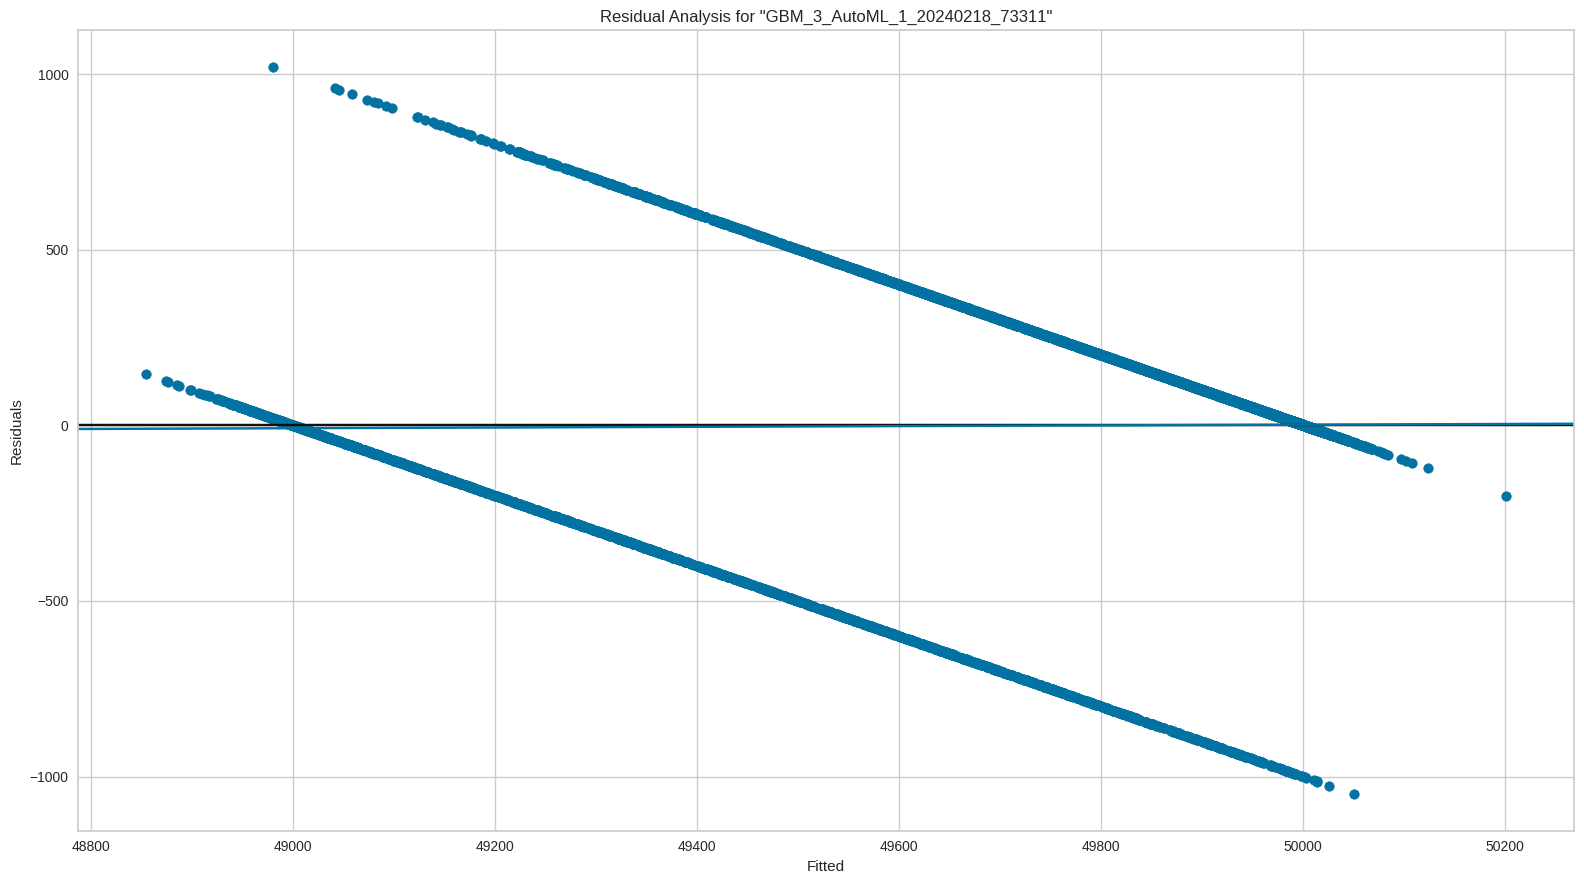

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

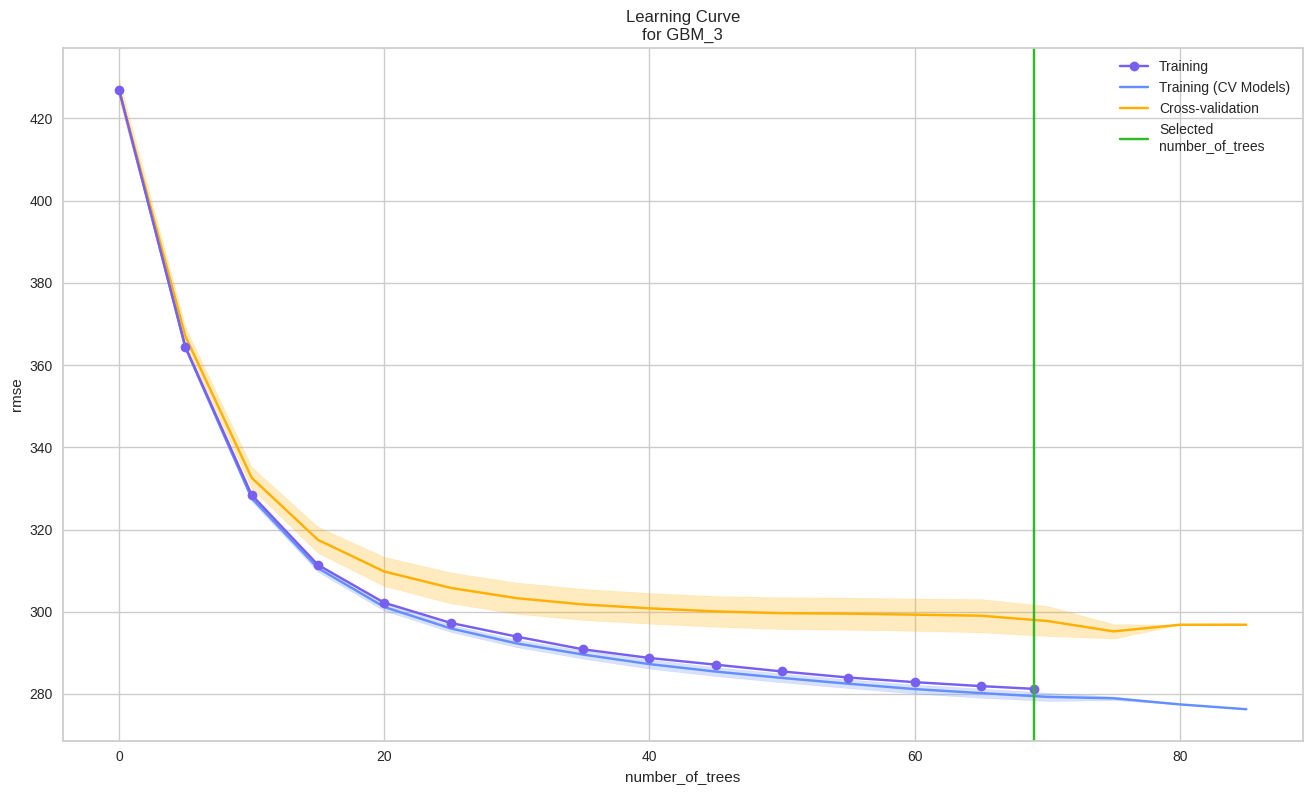

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

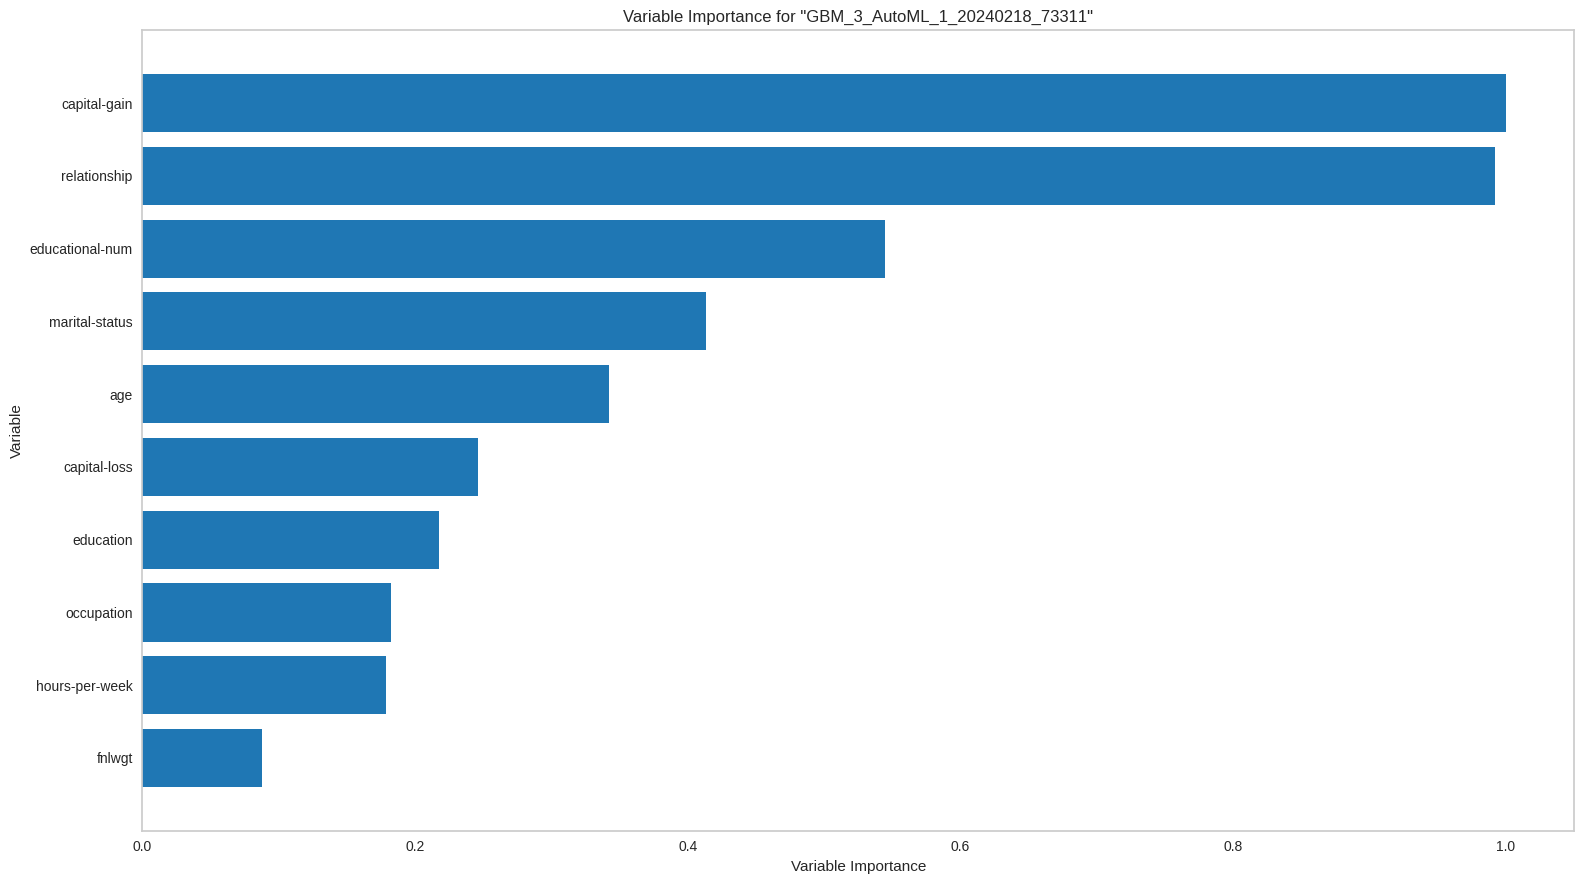

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

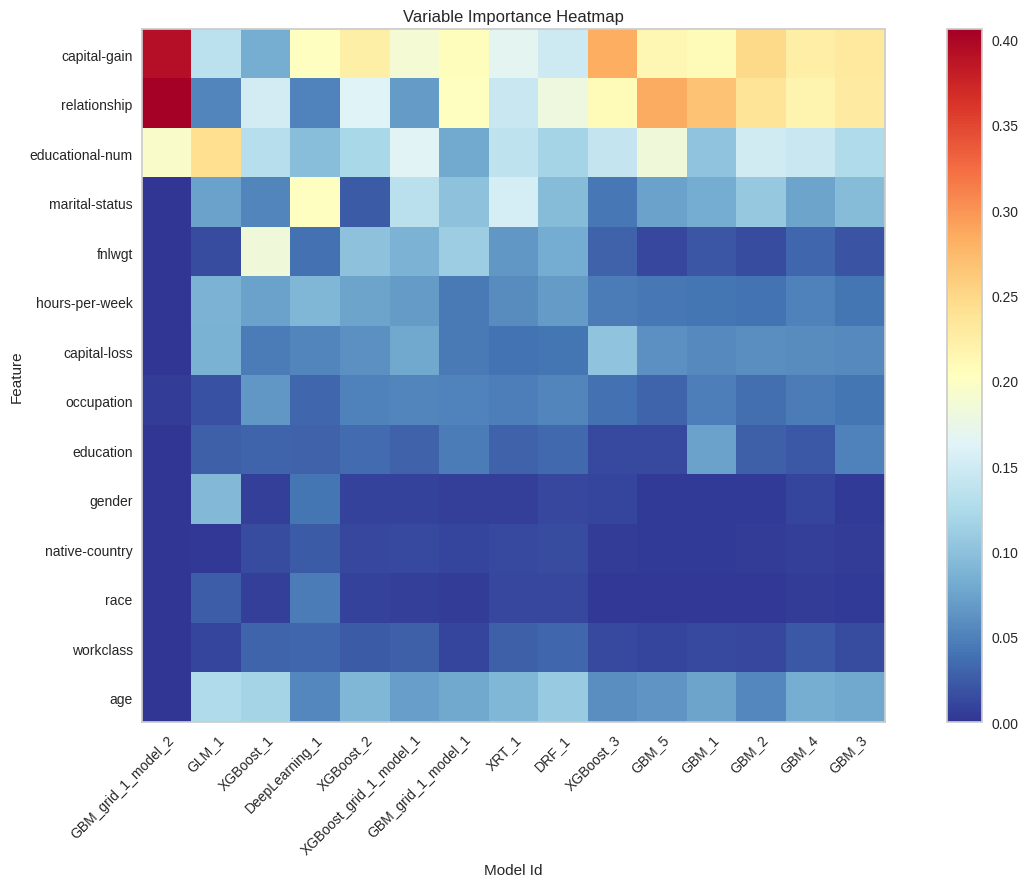

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

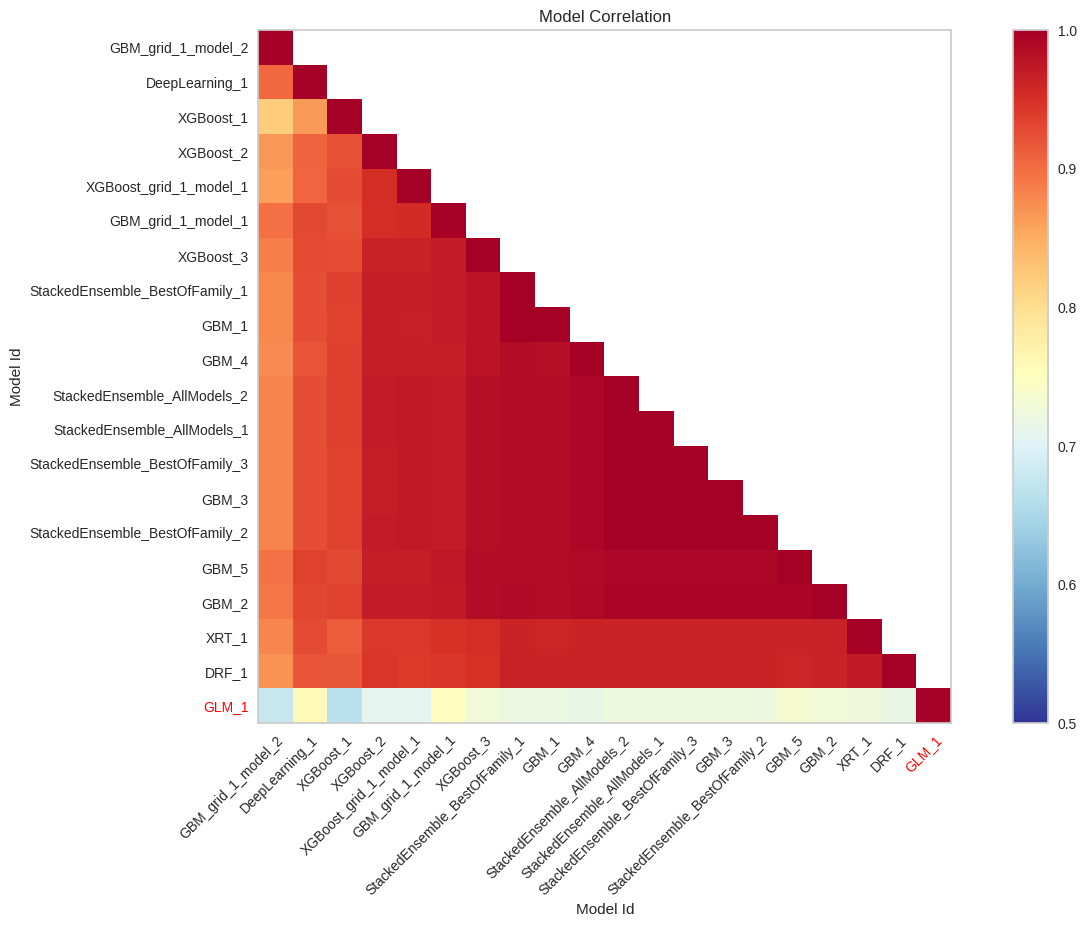

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

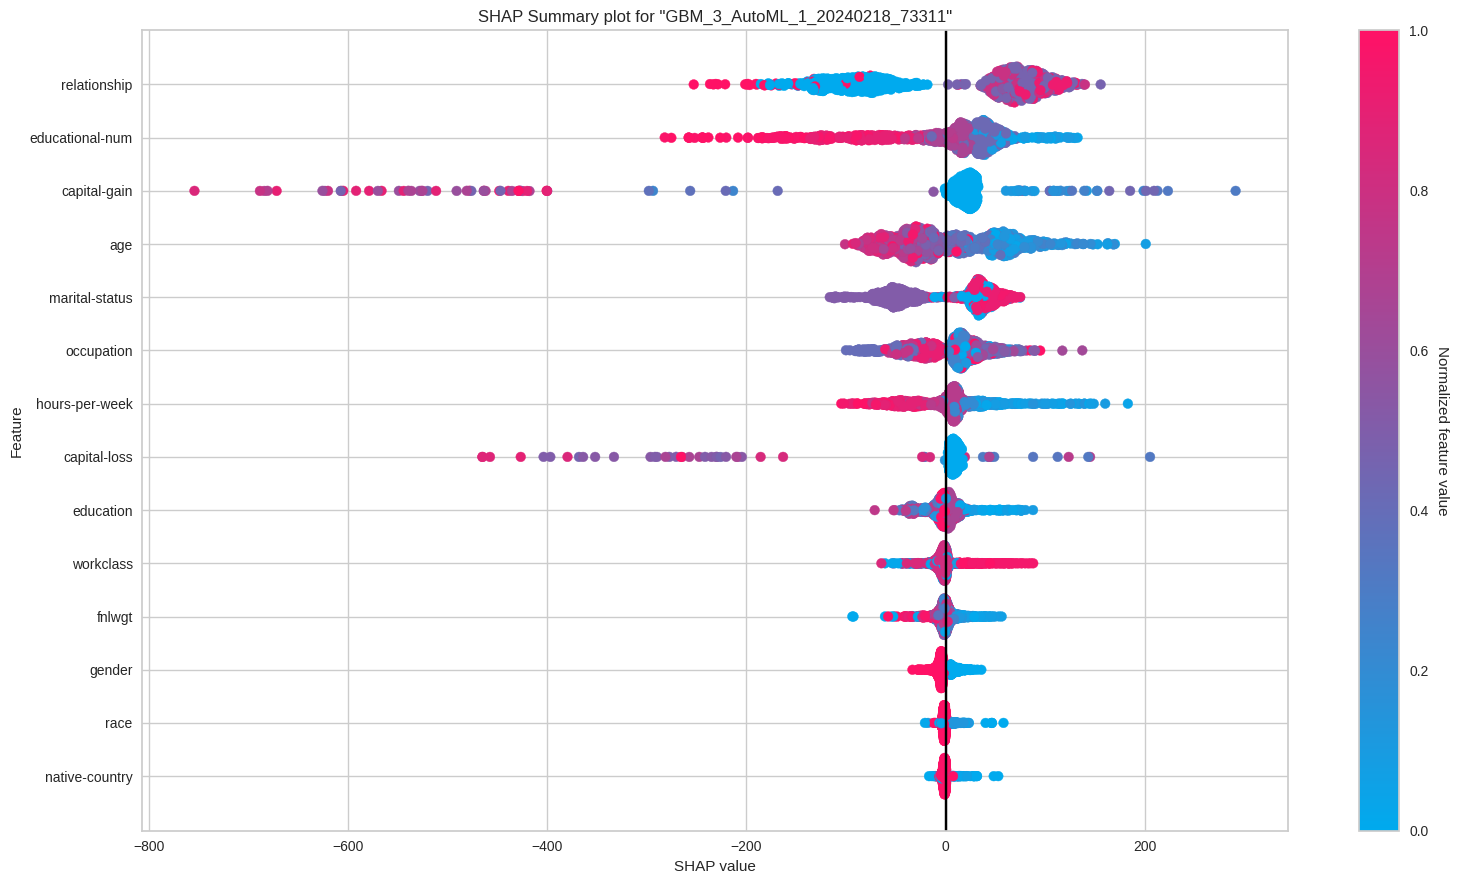

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

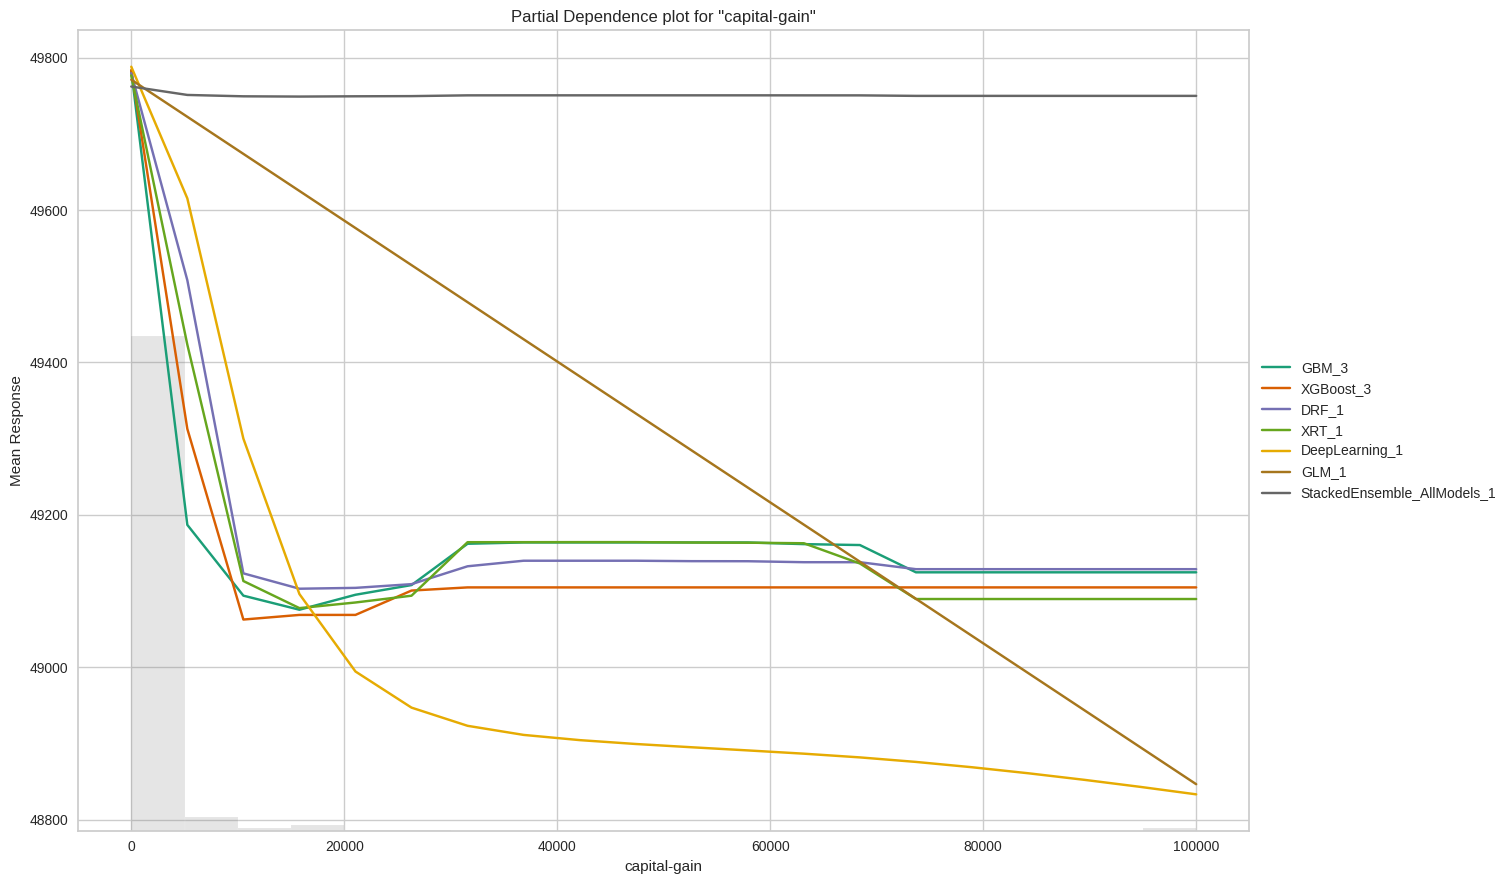

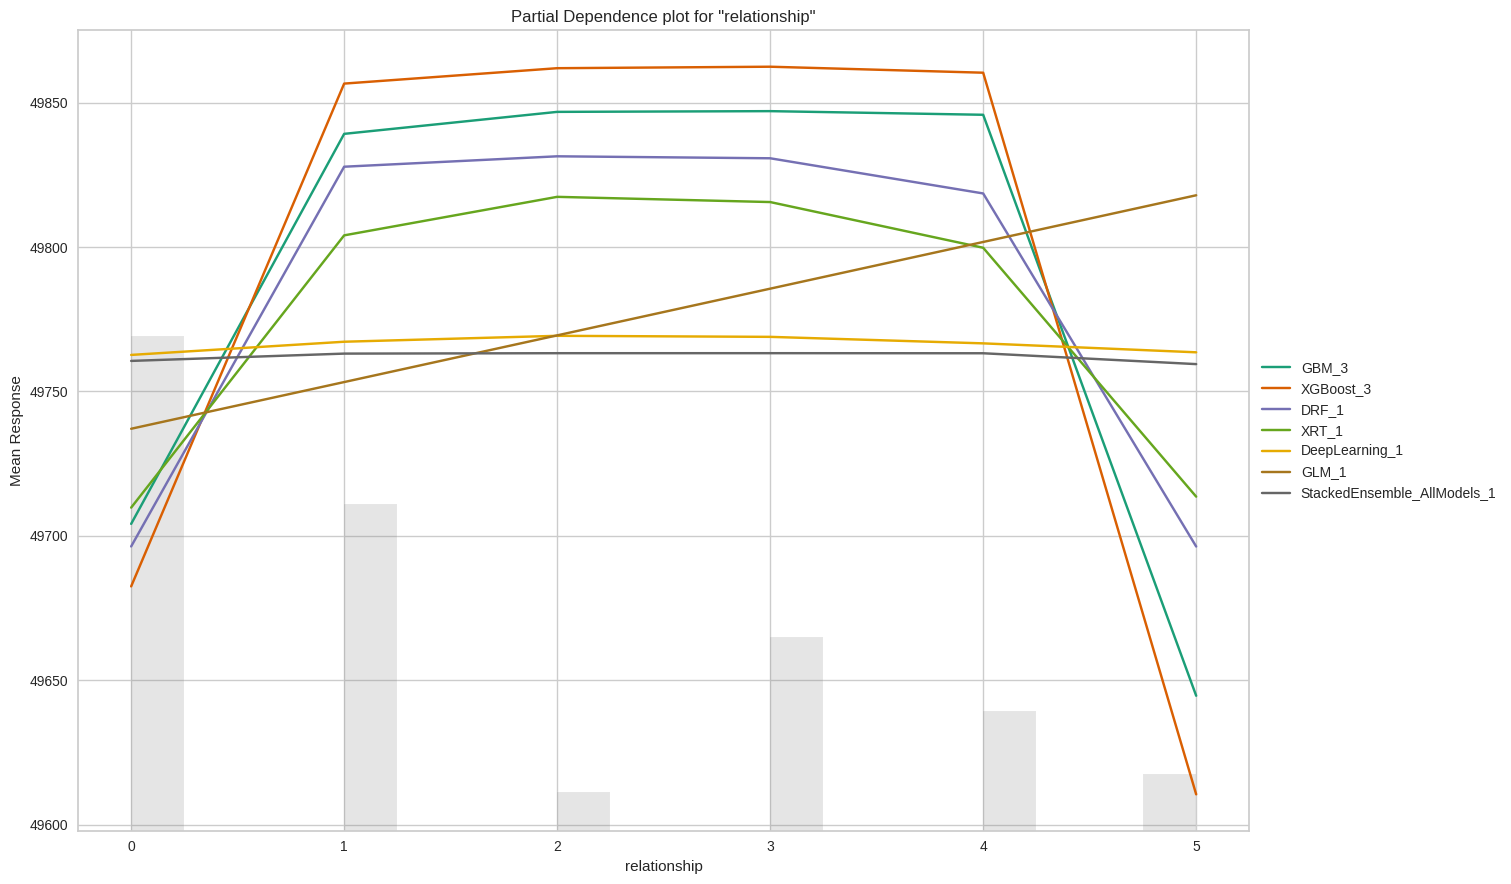

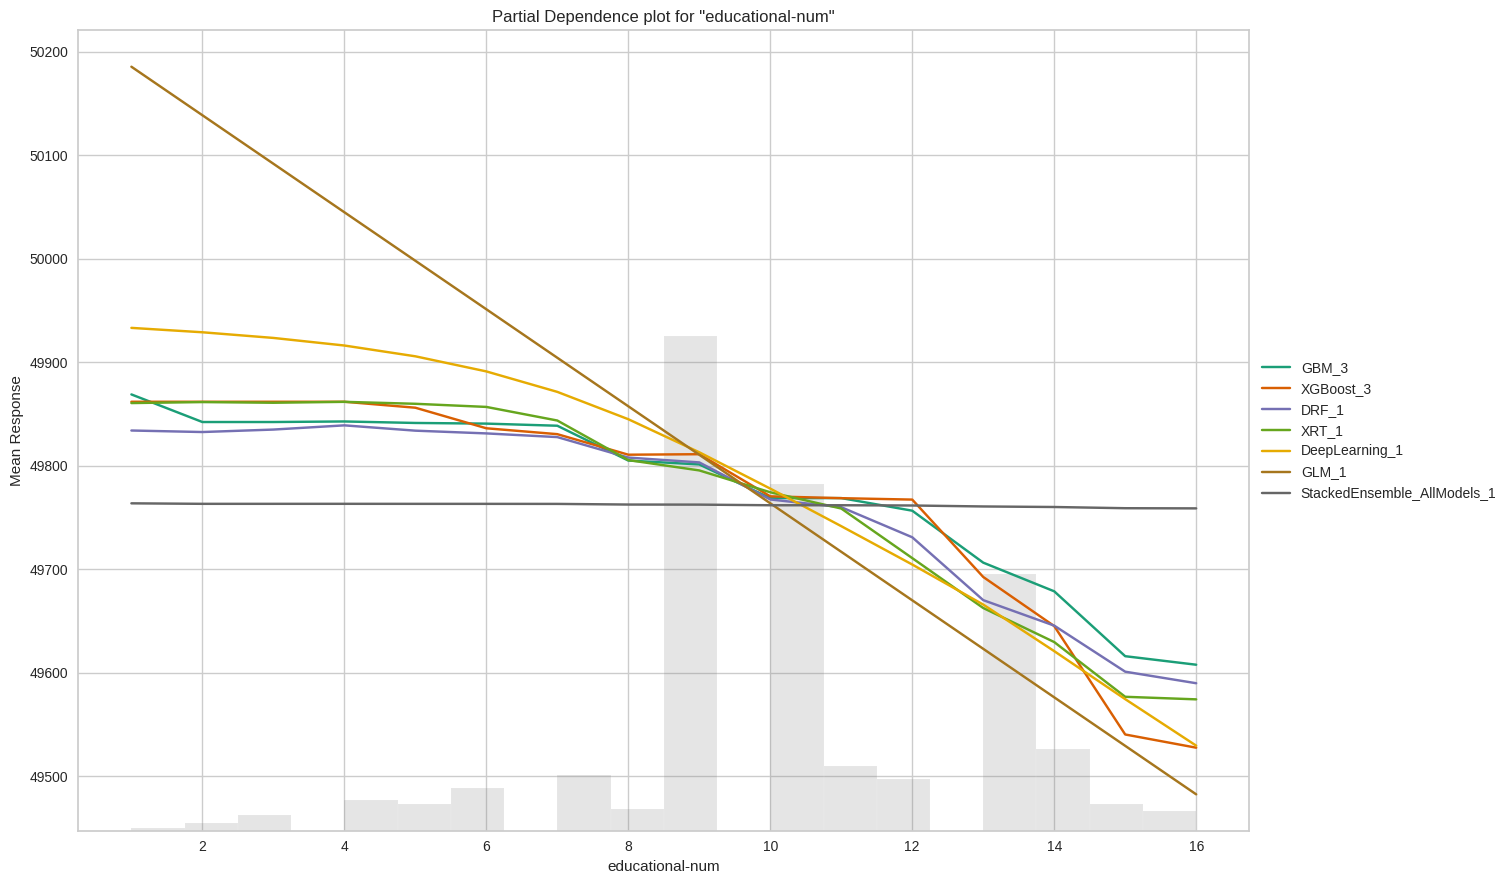

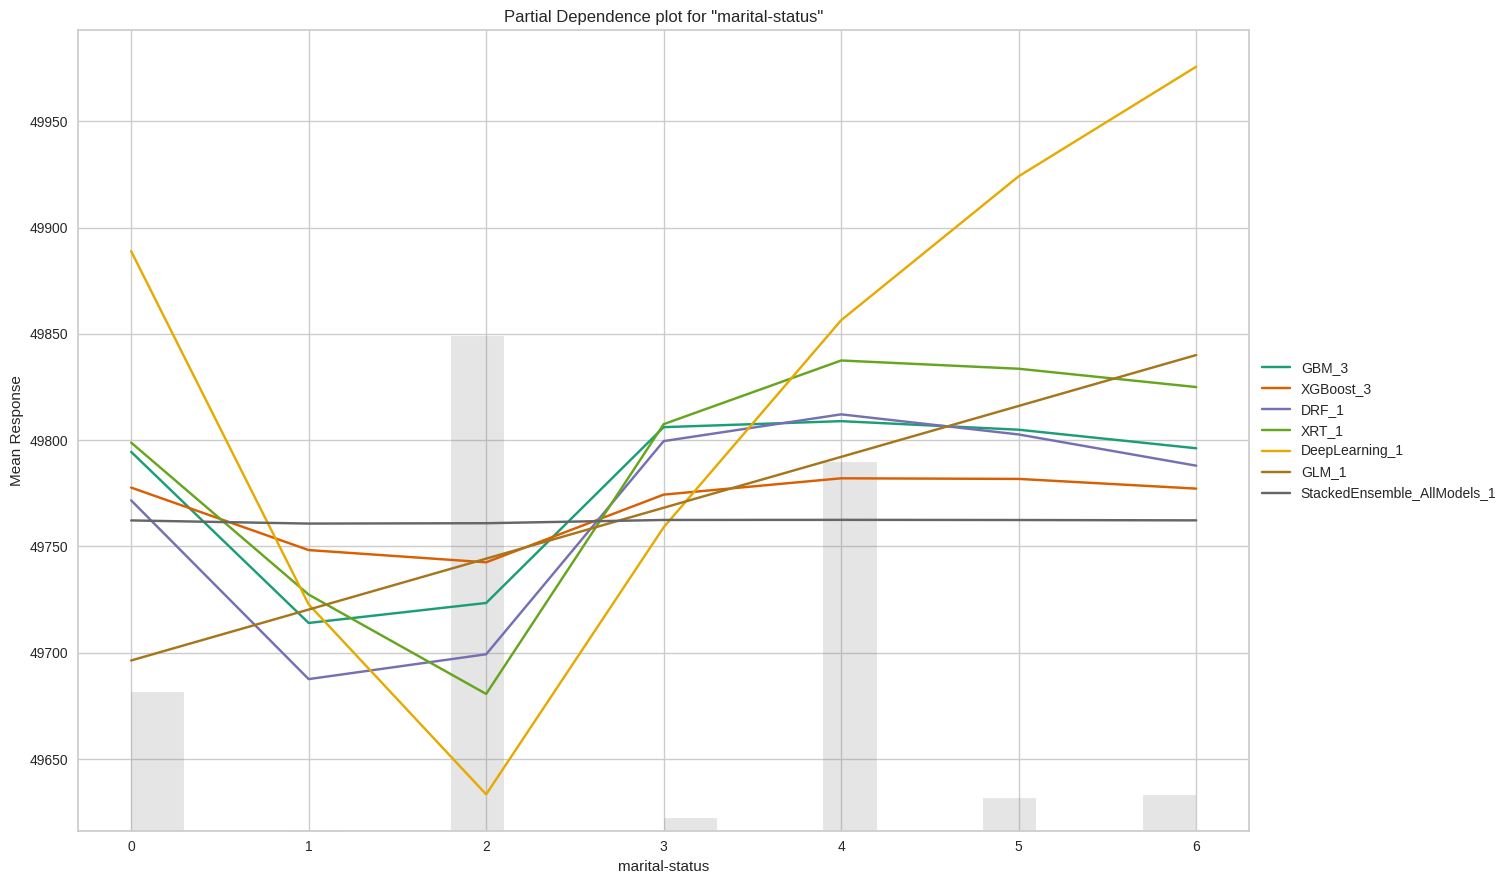

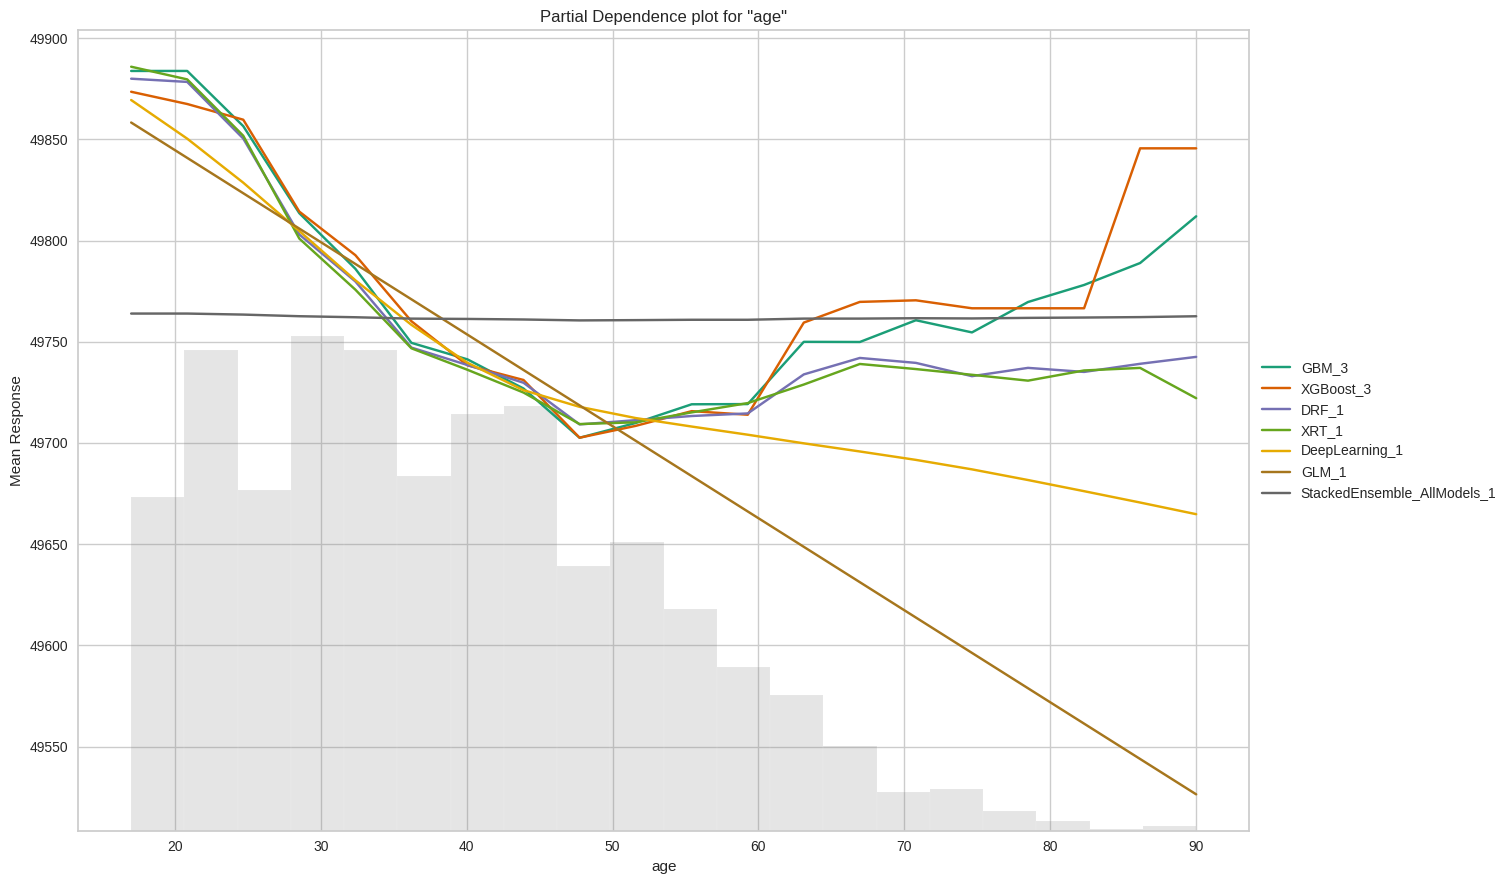

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

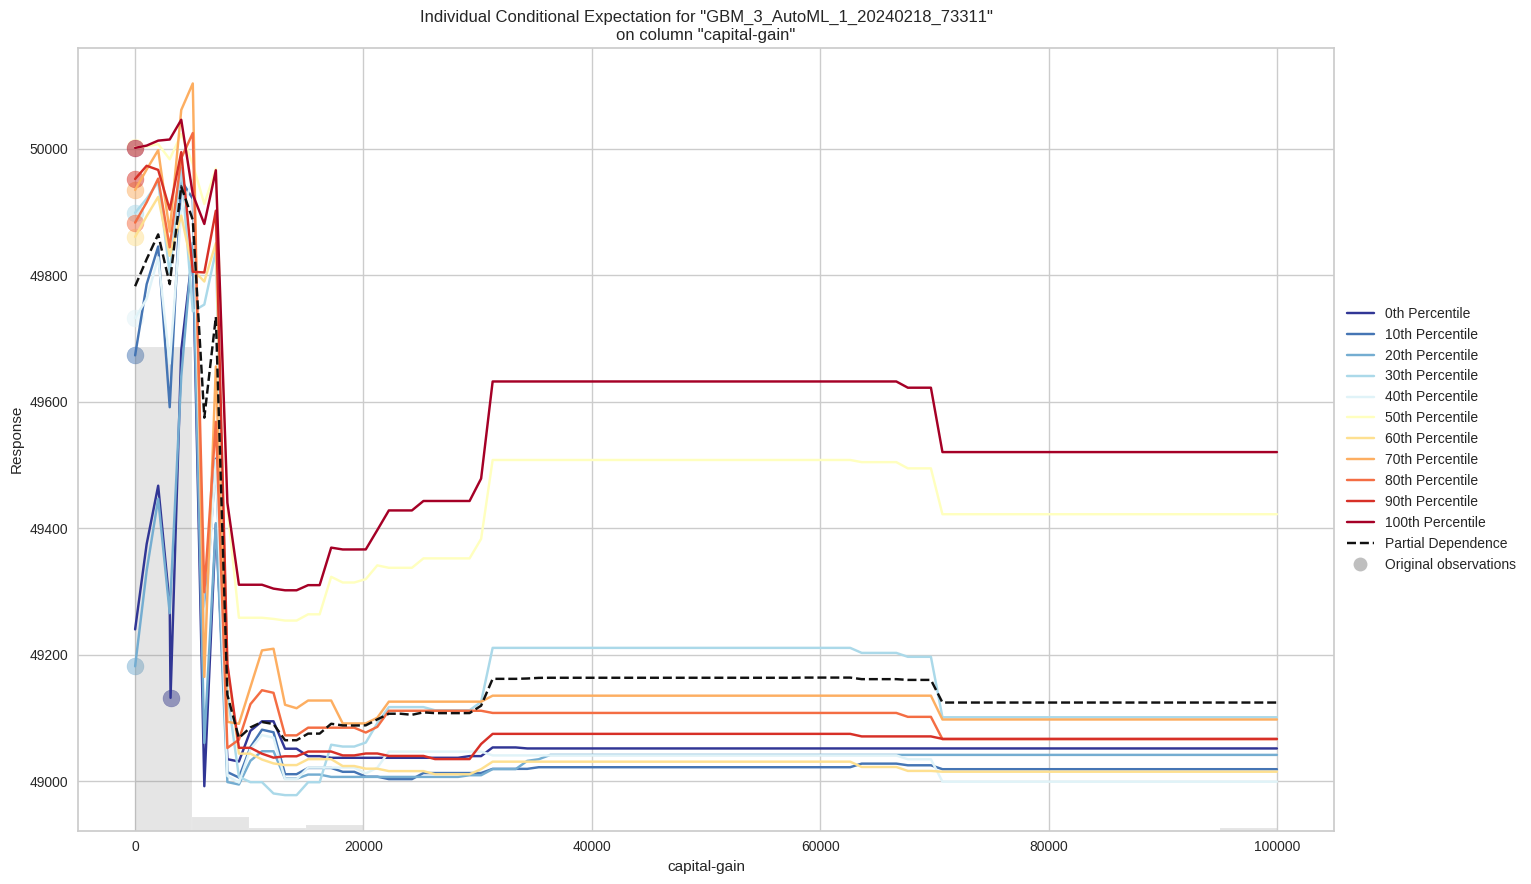

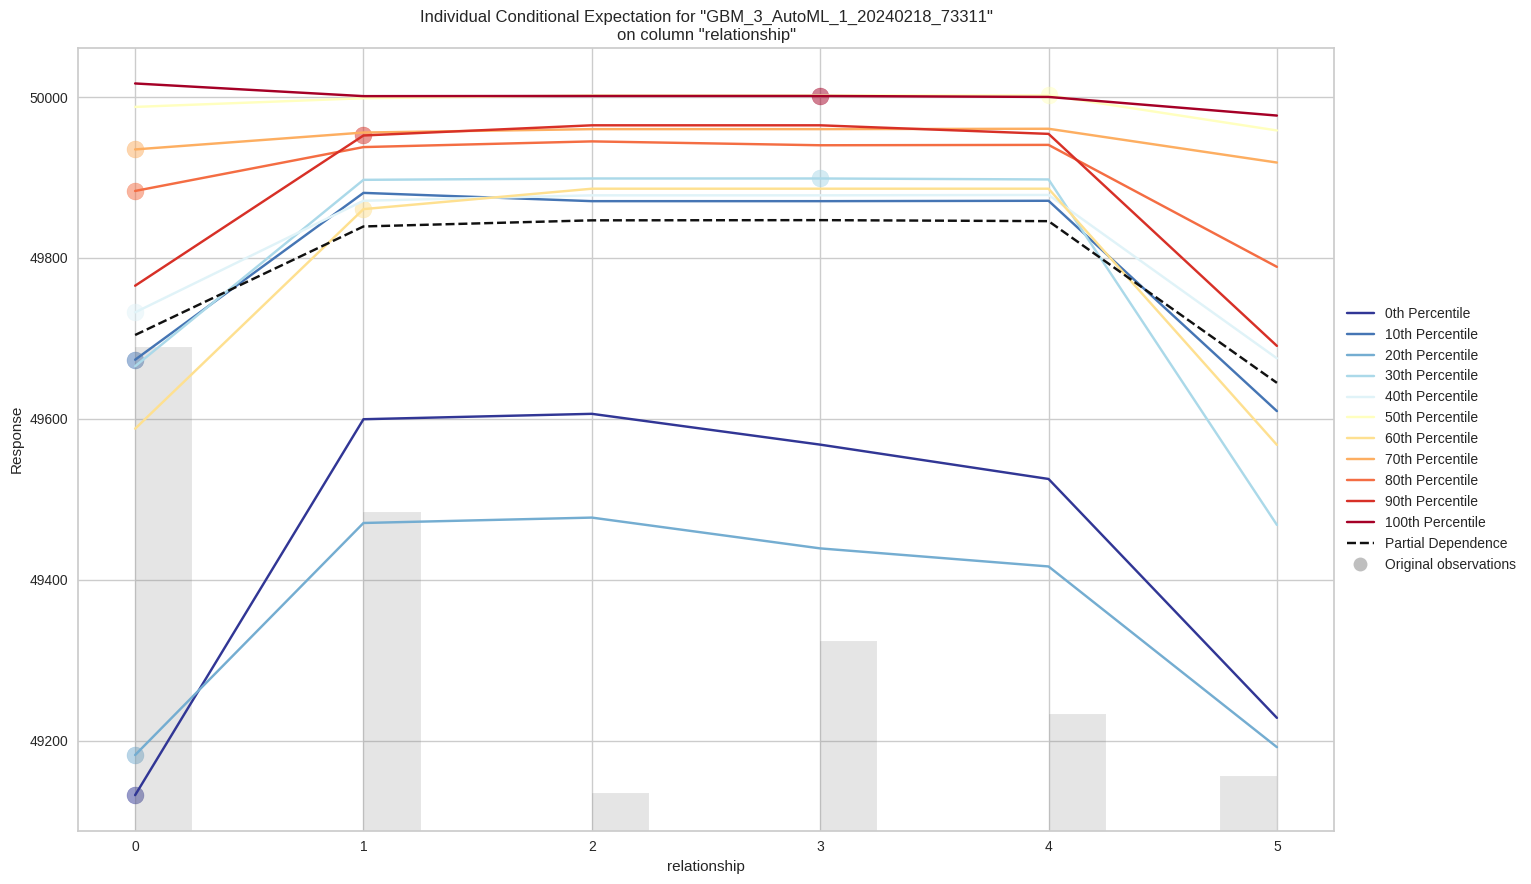

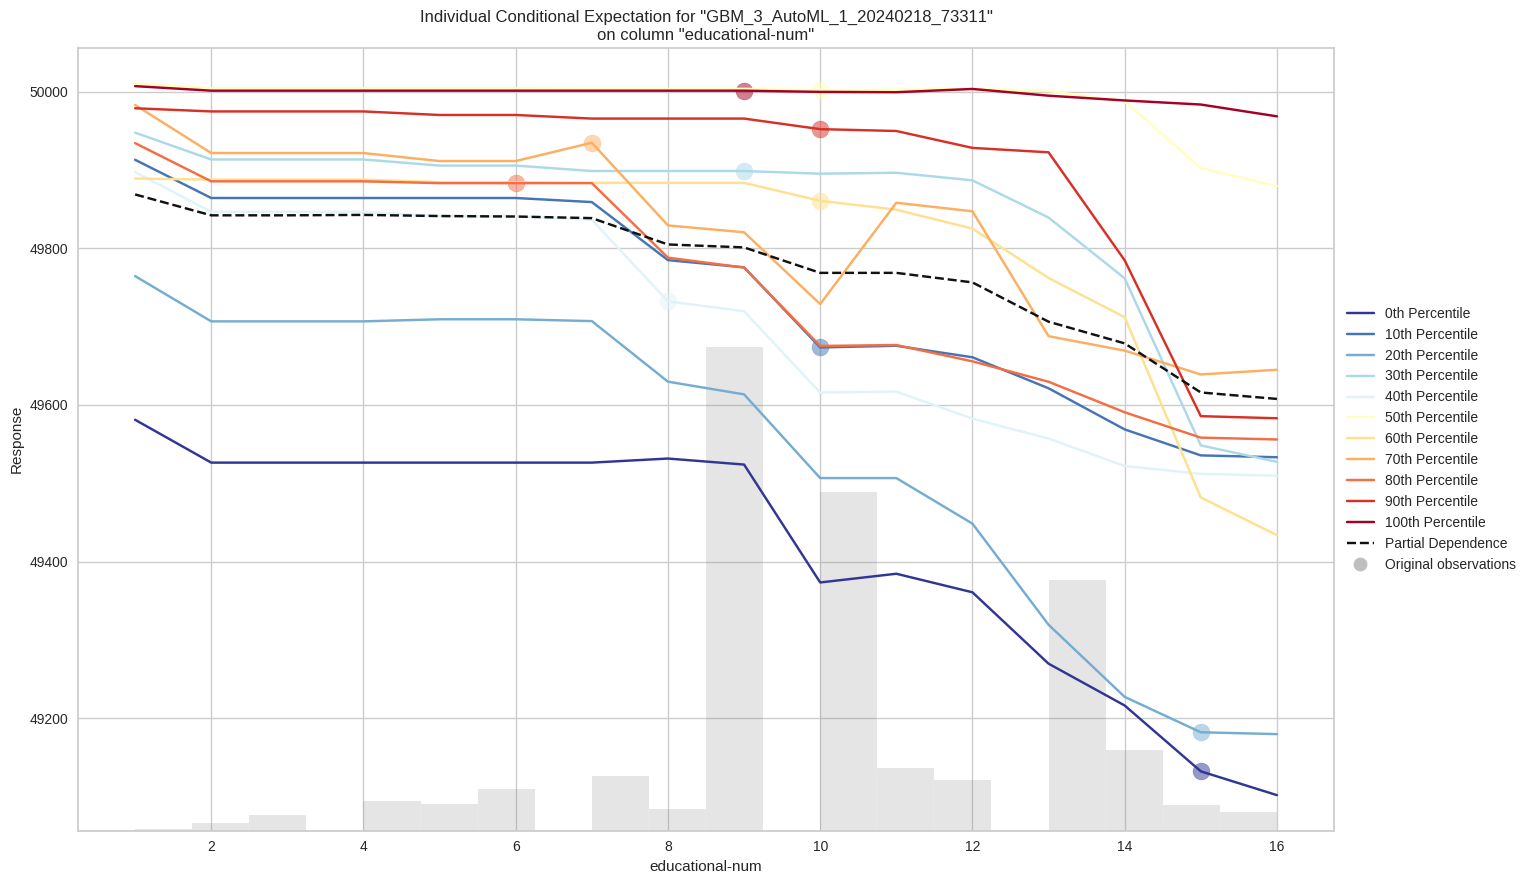

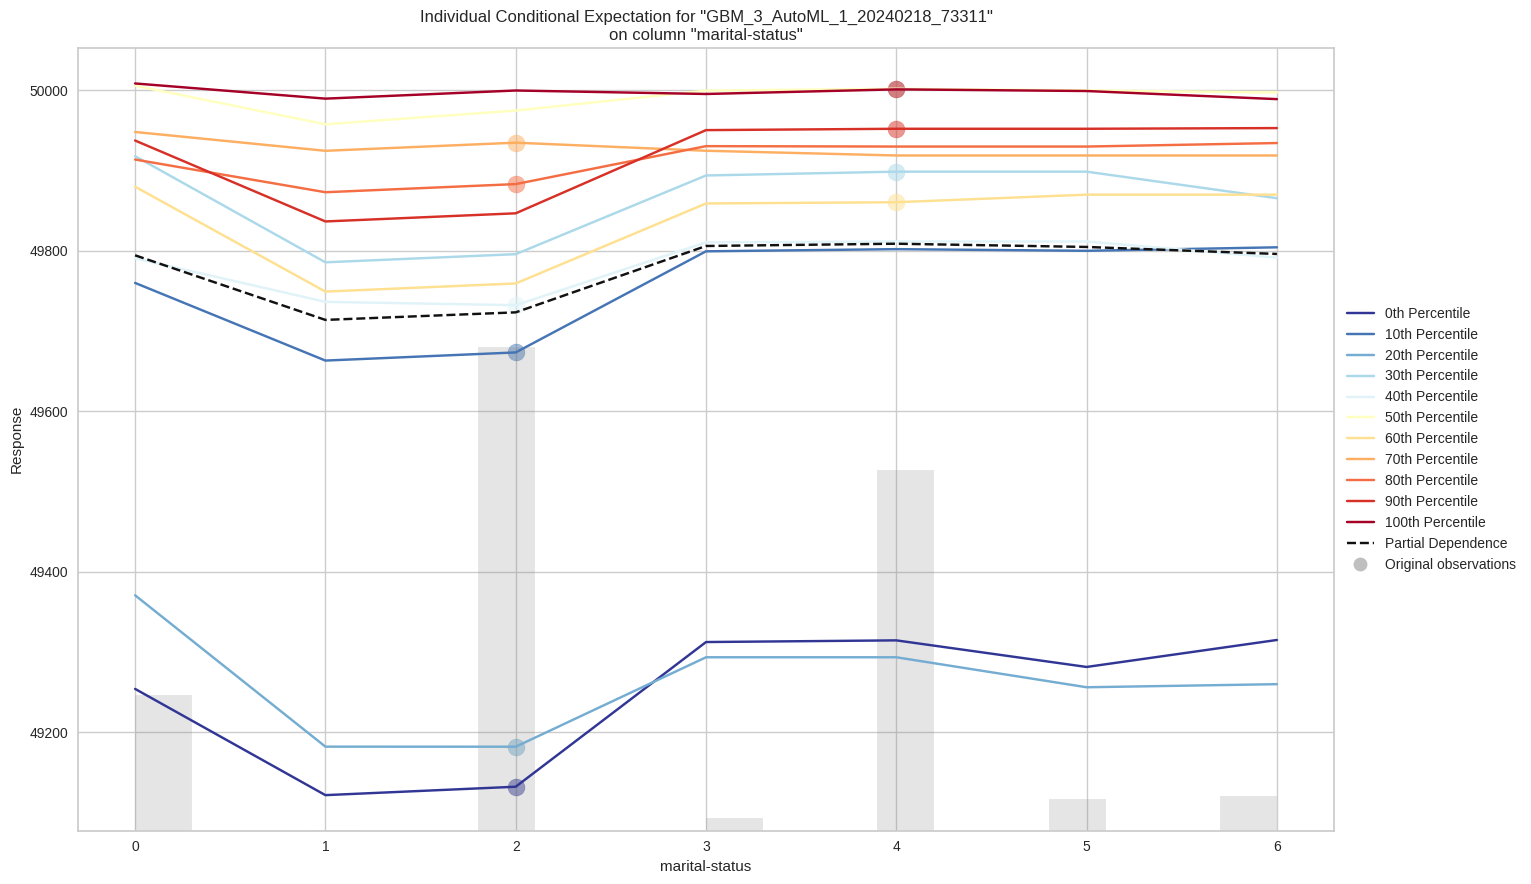

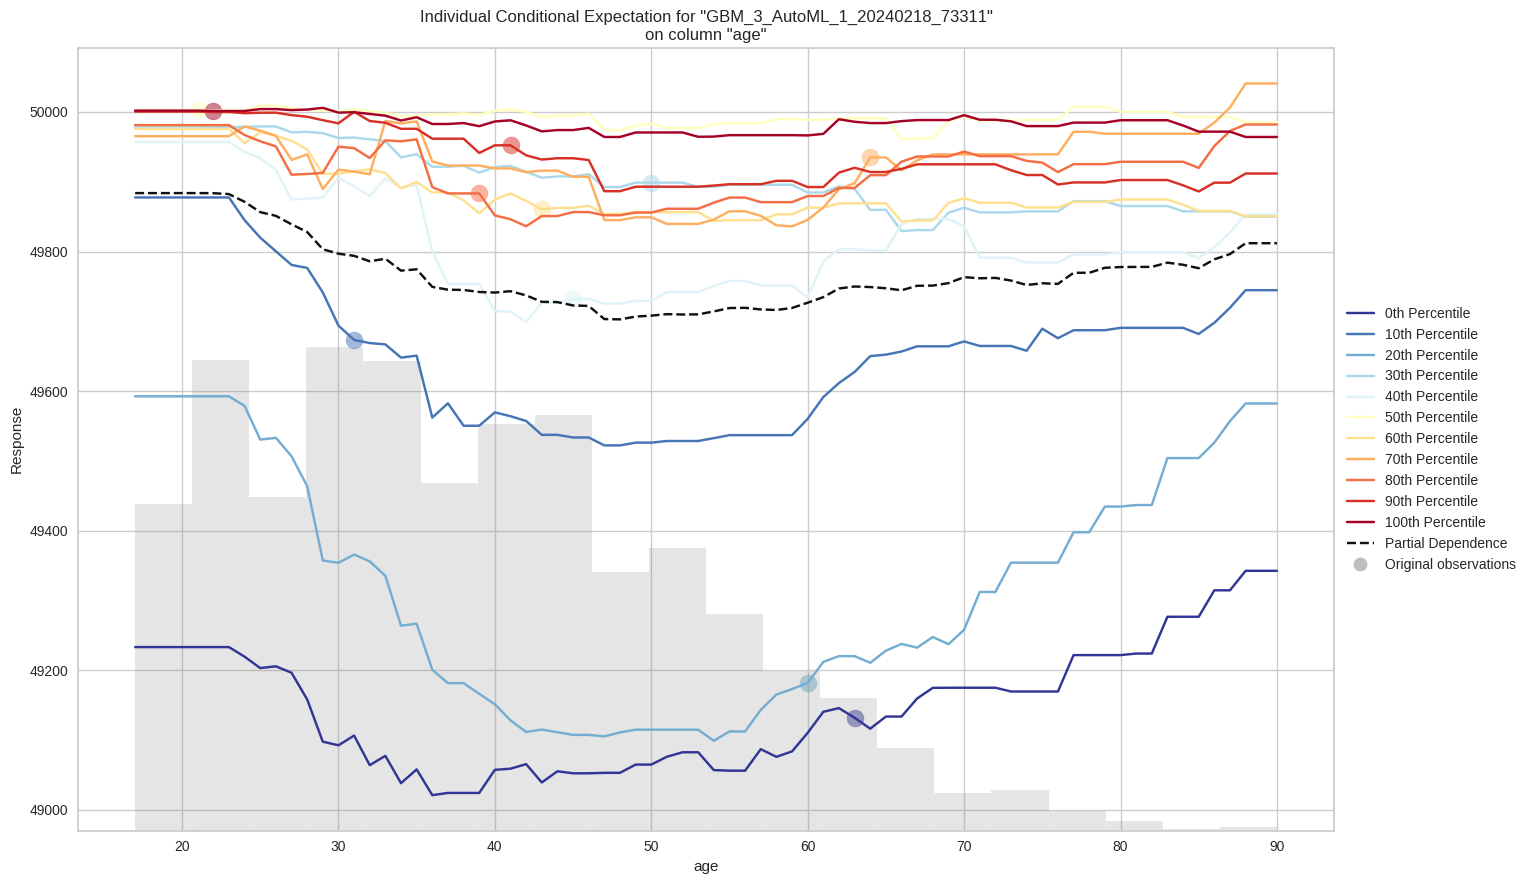

In [50]:
exa = aml.explain(df_test)

In [71]:
train, validate, test = np.split(
    ddf.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

train = h2o.H2OFrame(train)
validate = h2o.H2OFrame(validate)
test = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [72]:
gbm_parameters = {
    "learn_rate": [i * 0.01 for i in range(1, 11)],
    "max_depth": list(range(2, 11)),
    "sample_rate": [i * 0.1 for i in range(5, 11)],
    "col_sample_rate": [i * 0.1 for i in range(1, 11)],
}

In [73]:
search_criteria = {"strategy": "RandomDiscrete", "max_models": 36, "seed": 1}

In [79]:
gbm_grid2 = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    grid_id="gbm_grid2",
    hyper_params=gbm_parameters,
    search_criteria=search_criteria,
)

In [80]:

gbm_grid2.train(
    x=X, y=y, training_frame=train, validation_frame=validate, ntrees=100, seed=1
)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,sample_rate,model_ids,residual_deviance
,0.5,0.1,9.0,1.0,gbm_grid2_model_7,91232.4361541
,0.5,0.05,7.0,0.9,gbm_grid2_model_2,91234.9175444
,0.8,0.06,9.0,0.6000000,gbm_grid2_model_30,91262.6894519
,0.9,0.09,8.0,0.9,gbm_grid2_model_36,91417.7196149
,0.4,0.08,6.0,0.9,gbm_grid2_model_28,91708.7738092
,0.8,0.03,9.0,0.9,gbm_grid2_model_8,92070.0310540
,0.9,0.03,10.0,0.5,gbm_grid2_model_21,92137.2178053
,0.9,0.09,9.0,0.6000000,gbm_grid2_model_3,92355.6191930
,0.9,0.1,4.0,0.7000000,gbm_grid2_model_15,92726.8251764
,0.7000000,0.06,5.0,0.6000000,gbm_grid2_model_14,92777.3548583


In [81]:
gbm_gridperf2 = gbm_grid2.get_grid(sort_by="residual_deviance", decreasing=False)

In [82]:
gbm_gridperf2

,col_sample_rate,learn_rate,max_depth,sample_rate,model_ids,residual_deviance
,0.5,0.1,9.0,1.0,gbm_grid2_model_7,91232.4361541
,0.5,0.05,7.0,0.9,gbm_grid2_model_2,91234.9175444
,0.8,0.06,9.0,0.6000000,gbm_grid2_model_30,91262.6894519
,0.9,0.09,8.0,0.9,gbm_grid2_model_36,91417.7196149
,0.4,0.08,6.0,0.9,gbm_grid2_model_28,91708.7738092
,0.8,0.03,9.0,0.9,gbm_grid2_model_8,92070.0310540
,0.9,0.03,10.0,0.5,gbm_grid2_model_21,92137.2178053
,0.9,0.09,9.0,0.6000000,gbm_grid2_model_3,92355.6191930
,0.9,0.1,4.0,0.7000000,gbm_grid2_model_15,92726.8251764
,0.7000000,0.06,5.0,0.6000000,gbm_grid2_model_14,92777.3548583


In [83]:
list_hyperparameters = []
for i in range(36):
    hyperparameters = gbm_gridperf2.get_hyperparams_dict(i)
    list_hyperparameters.append(hyperparameters)

Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperp

In [84]:
models = gbm_gridperf2.models

In [85]:
list_residual_deviance = []
for i in range(36):
    model = models[i]
    performance_metrics = model.model_performance(validate)
    residual_deviance = performance_metrics.mean_residual_deviance()
    list_residual_deviance.append(residual_deviance)

In [86]:
for i in range(36):
    list_hyperparameters[i]["Residual_Deviance"] = list_residual_deviance[i]

In [87]:
hyperparameters_dataframe = pd.DataFrame(list_hyperparameters)

In [88]:
print(hyperparameters_dataframe)

    col_sample_rate  learn_rate  max_depth  sample_rate  Residual_Deviance
0               0.5        0.10          9          1.0       91232.436154
1               0.5        0.05          7          0.9       91234.917544
2               0.8        0.06          9          0.6       91262.689452
3               0.9        0.09          8          0.9       91417.719615
4               0.4        0.08          6          0.9       91708.773809
5               0.8        0.03          9          0.9       92070.031054
6               0.9        0.03         10          0.5       92137.217805
7               0.9        0.09          9          0.6       92355.619193
8               0.9        0.10          4          0.7       92726.825176
9               0.7        0.06          5          0.6       92777.354858
10              0.3        0.03          8          1.0       93827.882945
11              0.5        0.10          4          0.8       93976.911307
12              0.6      

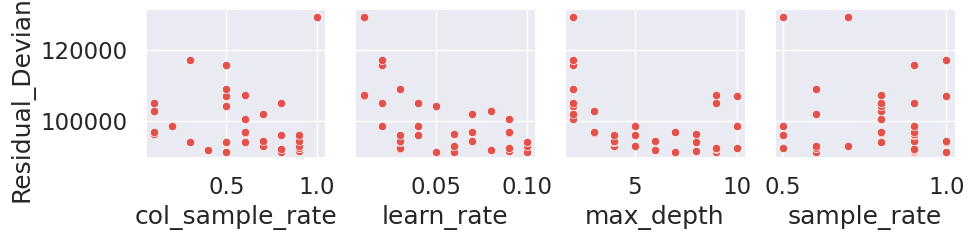

In [89]:
sns.pairplot(
    hyperparameters_dataframe,
    y_vars=["Residual_Deviance"],
    x_vars=["col_sample_rate", "learn_rate", "max_depth", "sample_rate"],
)